### Exercise A: Constructing a Low-Volatility Index ###

In [1]:
import pandas as pd
import yfinance as yf

In [2]:
import matplotlib.pyplot as plt
#plt.rcParams["figure.dpi"] = 100
#plt.rcParams["figure.figsize"] = [9., 6.]

In [3]:
tickers = ["JNJ", "MRK", "PFE", "BMY", "CTLT", "LLY", "VTRS", "PRGO", "ZTS"]
dfPx = yf.download(" ".join(tickers), start="2000-01-01")["Adj Close"]

[*********************100%***********************]  9 of 9 completed


<AxesSubplot:title={'center':'Pharma stocks'}, xlabel='Date'>

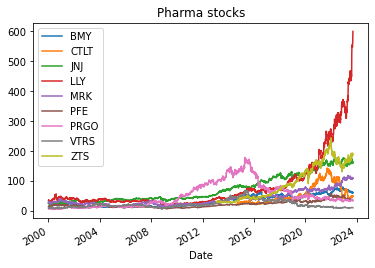

In [4]:
dfPx.plot(title="Pharma stocks")

In [5]:
dfPx = dfPx.loc[:, [dfPx[[ii]].isna().sum().sum() < 100 for ii in dfPx.columns]]
dfPx.fillna(method="ffill", limit=3, inplace=True)
dfRets = dfPx.pct_change().dropna()

C:\Users\cyril\anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [6]:
dfStds = dfRets.rolling(200).std().dropna()
dfW = 1 / dfStds.shift(1)
dfW = dfW.div(dfW.sum(axis=1), axis=0)

<AxesSubplot:xlabel='Date'>

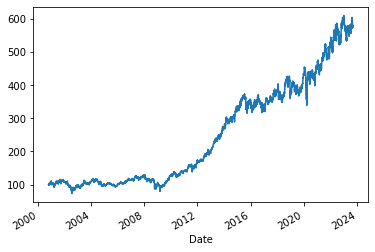

In [7]:
tsIndex = 100 * (1 + (dfW * dfRets).sum(axis=1)).cumprod()[dfW.index.min():]
tsIndex.plot()

### Exercise B: Brute-Force Sharpe Ratio Optimization ###

In [8]:
import numpy as np
from scipy import optimize

In [9]:
def fnObj(w, C, M, Rf=0):
    return float((Rf - w.dot(M)) / np.sqrt(w.dot(C).dot(w.T)))

In [10]:
dfW0 = pd.DataFrame(index=dfRets.index, columns=dfRets.columns)

In [11]:
cons = [{"type" : "eq", "fun" : lambda x: np.sum(x) - 1},
       {"type" : "ineq", "fun" : lambda x: np.min(x)}]

In [12]:
# 5257 rows take a long time...
for ii in range(200, dfRets.shape[0]):
    df = dfRets[(ii - 200):ii]
    res = optimize.minimize(fnObj, np.ones(df.shape[1]) / df.shape[1],
        args=(df.cov().values, df.mean().values), constraints=cons)
    dfW0.iloc[ii, :] = res.x if res.success else None

In [13]:
dfW0.dropna(inplace=True)
tsIndex0 = 100 * (1 + (dfW0 * dfRets).sum(axis=1)).cumprod()[dfW0.index.min():]

<AxesSubplot:xlabel='Date'>

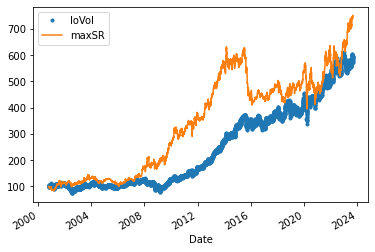

In [14]:
pd.merge(tsIndex.rename("loVol"), tsIndex0.rename("maxSR"),
         left_index=True, right_index=True).plot(style=[".", "-"])

### Exercise C: Estimation of Risk Premia Series ###

In [13]:
import pandas_datareader.data as pdr
import statsmodels.formula.api as smf

In [22]:
ff = pdr.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench", start="2000-01-01")[0]

In [15]:
panelData = dfPx.resample("M", kind="period").last().pct_change().dropna()
panelData = panelData.join(ff, how="inner")
panelData

,BMY,JNJ,LLY,MRK,PFE,PRGO,VTRS,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,,,,,,,
2000-02,-0.135849,-0.160384,-0.107491,-0.217011,-0.110010,-0.145455,-0.136150,2.45,18.28,-9.59,-18.65,-0.48,0.43
2000-03,-0.002184,-0.024306,0.053628,0.013913,0.138132,0.034043,0.197486,5.20,-15.32,8.13,11.79,-1.59,0.47
2000-04,-0.078649,0.174377,0.231537,0.118712,0.152137,-0.251029,0.031818,-6.40,-5.01,7.26,7.66,5.65,0.46
2000-05,0.050059,0.088785,-0.009633,0.077909,0.058445,0.054945,-0.055066,-4.42,-3.81,4.75,4.13,1.37,0.50
2000-06,0.057889,0.138269,0.311987,0.026800,0.078652,0.052083,-0.322444,4.64,9.92,-8.42,-8.31,-2.95,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03,0.005075,0.011353,0.103464,0.008374,0.005669,-0.041226,-0.146596,2.51,-6.94,-8.85,2.24,-2.37,0.36
2023-04,-0.028718,0.056129,0.152699,0.085346,-0.046814,0.036799,-0.030146,0.61,-2.56,-0.04,2.42,2.86,0.35
2023-05,-0.034896,-0.045633,0.087701,-0.043821,-0.011792,-0.140629,-0.006706,0.35,-0.38,-7.72,-1.81,-7.22,0.36


In [16]:
panelData.rename(columns=lambda x: x.replace("-", "_"), inplace=True)

In [17]:
tickers = dfPx.columns.tolist()
res = pd.DataFrame({ii : smf.ols(ii + " ~ Mkt_RF + SMB + HML + RMW + CMA",
                                 data=panelData).fit().params for ii in tickers})
res

,BMY,JNJ,LLY,MRK,PFE,PRGO,VTRS
Intercept,0.000777,0.002504,0.007452,0.002195,-0.001415,0.006275,-0.002667
Mkt_RF,0.006353,0.005804,0.005815,0.006945,0.007753,0.006513,0.009266
SMB,-0.003831,-0.002752,-0.003431,-0.008418,-0.004240,-0.000418,-0.002928
HML,0.000312,-0.000920,-0.003728,-0.001901,-0.000969,0.004037,0.002925
RMW,0.000911,0.003601,0.000446,0.000447,0.002943,-0.000262,0.002815
CMA,0.005219,0.004842,0.008298,0.009361,0.005894,-0.001015,0.003651


In [18]:
idx = panelData.index
panelData.index = ["z" + str(ii) for ii in range(len(idx))]
res0 = pd.concat([res, panelData[tickers]]).T
res0

,Intercept,Mkt_RF,SMB,HML,RMW,CMA,z0,z1,z2,z3,...,z272,z273,z274,z275,z276,z277,z278,z279,z280,z281
BMY,0.000777,0.006353,-0.003831,0.000312,0.000911,0.005219,-0.135849,-0.002184,-0.078649,0.050059,...,0.098044,0.036272,-0.103762,0.017717,-0.050791,0.005075,-0.028718,-0.034896,-0.007604,-0.018882
JNJ,0.002504,0.005804,-0.002752,-0.000920,0.003601,0.004842,-0.160384,-0.024306,0.174377,0.088785,...,0.064949,0.029769,-0.007584,-0.074894,-0.055426,0.011353,0.056129,-0.045633,0.067458,0.012144
LLY,0.007452,0.005815,-0.003431,-0.003728,0.000446,0.008298,-0.107491,0.053628,0.231537,-0.009633,...,0.119808,0.027687,-0.014121,-0.059288,-0.092759,0.103464,0.152699,0.087701,0.092023,-0.030769
MRK,0.002195,0.006945,-0.008418,-0.001901,0.000447,0.009361,-0.217011,0.013913,0.118712,0.077909,...,0.175105,0.088142,0.014213,-0.031906,-0.010893,0.008374,0.085346,-0.043821,0.052087,-0.075743
PFE,-0.001415,0.007753,-0.004240,-0.000969,0.002943,0.005894,-0.110010,0.138132,0.152137,0.058445,...,0.063757,0.086136,0.022142,-0.130261,-0.081295,0.005669,-0.046814,-0.011792,-0.035245,-0.005950
PRGO,0.006275,0.006513,-0.000418,0.004037,-0.000262,-0.001015,-0.145455,0.034043,-0.251029,0.054945,...,0.129557,-0.199851,0.066312,0.097682,0.007216,-0.041226,0.036799,-0.140629,0.071417,0.079234
VTRS,-0.002667,0.009266,-0.002928,0.002925,0.002815,0.003651,-0.136150,0.197486,0.031818,-0.055066,...,0.188967,0.100756,0.009066,0.092543,-0.062500,-0.146596,-0.030146,-0.006706,0.090710,0.055110


In [19]:
res2 = pd.DataFrame({"z" + str(ii) : smf.ols(
    "z" + str(ii) + " ~ Mkt_RF + SMB + HML + RMW + CMA",
    data=res0).fit().params for ii in range(len(idx))})
res2.columns = idx
res2.T.describe()

,Intercept,Mkt_RF,SMB,HML,RMW,CMA
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,0.014054,-0.129004,0.653869,-0.938723,-0.990406,-0.345331
std,0.174426,31.815202,27.934212,46.152145,15.401193,47.005694
min,-0.582223,-80.147872,-85.318509,-161.203105,-58.278024,-151.080545
25%,-0.093030,-22.141012,-14.724283,-28.234381,-11.651935,-25.378056
50%,0.016917,-1.645276,1.468870,-0.090961,0.493524,-0.665195
75%,0.118975,18.403729,16.106249,27.936232,9.474756,29.533669
max,0.640985,128.289218,70.437553,132.574361,41.059084,127.060670


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

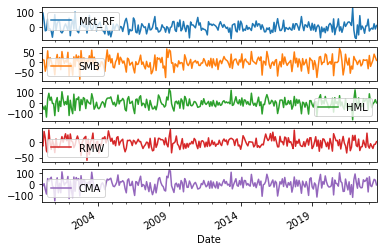

In [20]:
res3 = res2.T.iloc[:, 1:]
res3.plot(subplots=True)

<AxesSubplot:xlabel='Date'>

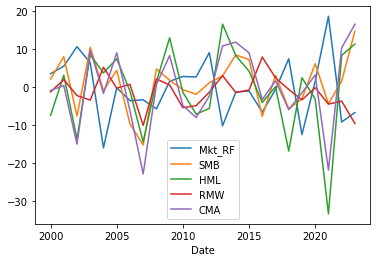

In [21]:
res3.groupby(res3.index.year).mean().plot()

In [24]:
ff.rename(columns=lambda x: x.replace("-", "_"), inplace=True)
dols = {ii : smf.ols(ii + " ~ Mkt_RF + SMB + HML + RMW + CMA - " + ii,
                     data=ff).fit() for ii in ff.columns}
pd.DataFrame({ii : [dols[ii].params.Intercept, dols[ii].pvalues.Intercept]
              for ii in ff.columns}, index=["Intercept", "pvalue"]).T[:-1]

,Intercept,pvalue
Mkt_RF,0.873197,0.000706
SMB,0.427244,0.008877
HML,-0.415661,0.008380
RMW,0.605464,0.000013
CMA,0.309253,0.003427
